In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.stats as stats
import pandas as pd
import pymc3 as pm
import seaborn as sns ## for making nice plots, we used this in Week 3 at the end
from theano import shared ## this is a new tool

## this is based on code from last week. To save time and typing, we can make it a function
def credible_interval_from_samples(samples, prob):
    """`samples` can be an nd array. Assume that all of the dimensions 
    except for the last index parameters while the last (rightmost) 
    dimension indexes the samples."""
    samples_sorted = sort(samples, axis=-1)
    N_samples = samples.shape[-1]
    index = int(N_samples*(1 - prob)/2)
    lower = samples_sorted[..., index]
    upper = samples_sorted[..., -index]
    return lower, upper

Populating the interactive namespace from numpy and matplotlib


ModuleNotFoundError: ignored

# Example: divorce rate in the 50 United States

In [ ]:
data = pd.read_csv('Data/WaffleDivorce.csv', delimiter=";")
data

In [ ]:
fig = figure(1, [15, 4])

fig.add_subplot(121)
plot(data['Marriage'], data['Divorce'], '.')
xlabel('marriage [per capita]', fontsize=20)
ylabel('divorce [per capita]', fontsize=20)

fig.add_subplot(122)
plot(data['MedianAgeMarriage'], data['Divorce'], '.')
xlabel('meadian age at marriage [years]', fontsize=20)
ylabel('divorce [per capita]', fontsize=20);

## Standardize the data so that it has mean zero and unit standard deviation

In [ ]:
data_standardized = pd.read_csv('Data/WaffleDivorce.csv', delimiter=";")
columns = ['MedianAgeMarriage', 'Marriage', 'Divorce']
data_standardized[columns] = (data[columns] - data[columns].mean())/data[columns].std()
data_standardized

In [ ]:
fig = figure(1, [15, 4])

fig.add_subplot(121)
plot(data_standardized['Marriage'], data_standardized['Divorce'], '.')
xlabel('marriage [standardized]', fontsize=20)
ylabel('divorce [standardized]', fontsize=20)

fig.add_subplot(122)
plot(data_standardized['MedianAgeMarriage'], data_standardized['Divorce'], '.')
xlabel('meadian age at marriage [standardized]', fontsize=20)
ylabel('divorce [standardized]', fontsize=20);

The author suggests that merely comparing parameter means between bivariate regressions is no way to decide which predictor is better. They may be independent, or related or could eliminate each other. How do we understand all this?

He explains that here we may want to think **causally**.

A few interesting observations:
  1. Age has a direct impact on Divorce rate as people may grow incompatible with the parter
  2. Marriage Rate has a direct impact on Divorce rate for obvious reason (more marriages => more divorce)
  3. Finally, Age has an impact on Marriage Rate because there are more young people

Another way to represent above is:
  1. A -> D
  2. M -> D
  3. A -> M

and yet another way is to use DAG (Directed Acyclic Graphs)

# Multiple regression model
 \begin{align*}
    D_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{M}M_{i} + \beta_{A}A_{i} \\
    \alpha &\sim \text{Normal}(0, 0.2) \\
    \beta_{M} &\sim \text{Normal}(0, 0.5) \\
    \beta_{A} &\sim \text{Normal}(0, 0.5) \\
    \sigma &\sim  \text{Exponential}(1)
  \end{align*}

In [ ]:
with pm.Model() as model_5_3:
    sigma = pm.Exponential('sigma', 1)
    beta_A = pm.Normal('beta_A', mu=0, sd=0.5)
    beta_M = pm.Normal('beta_M', mu=0, sd=0.5)
    alpha = pm.Normal('alpha', mu=0, sd=0.2)
    ## Note that an underscore '_' is nothing special;
    ## it is just another character that can be part of a variable name.
    _mu = alpha + beta_M*data_standardized['Marriage'] + beta_A*data_standardized['MedianAgeMarriage']
    mu = pm.Deterministic('mu', _mu) ## we use this so that we can sample the posterior predictive later
    D = pm.Normal('divorce', mu=mu, sd=sigma, observed=data_standardized['Divorce'])
    _model_5_3_mcmc_samples = pm.sample(1000, tune=1000)
model_5_3_mcmc_samples = pm.trace_to_dataframe(_model_5_3_mcmc_samples)
model_5_3_mcmc_samples

## Plot the posterior for $\beta_A$ and $\beta_M$ as a boxplot
The box shows the inter quartile range: 50% of the data around the median (horizontal black line).

In [ ]:
sns.boxplot(data=model_5_3_mcmc_samples[['beta_A', 'beta_M']])

## Plot the posterior for $\beta_A$ and $\beta_M$ as violin plot
A boxplot has one flaw, it has a hard time characterizing a multi model posterior (multiple peaks). An alternative is to use a tiny probability density to represent the data. This is essentially using a KDE (see Week 3 and 4 notebooks) in each column. **Note that in this case the posterior appears to be unimodel (i.e., a single peak).**

In [ ]:
sns.violinplot(data=model_5_3_mcmc_samples[['beta_A', 'beta_M']])

### Exercise: Compute a single variable regression for divorce rate vs marriage rate (see Week 4 notebook for examples). How does the parameter $\beta_M$ posterior distribution compare to the above from multiple regression? 

## Posterior predictive plots
The PyMC3 package gives us a big shortcut for computing posterior predictive samples. (Compare this to our code from Week 4.)

In [2]:
with model_5_3:
    posterior_predictive_samples = pm.sample_posterior_predictive(
        _model_5_3_mcmc_samples, 
        var_names=["mu", "divorce"], 
        samples=1000)
posterior_predictive_samples.keys() ## the output is a Python dictionary

NameError: ignored

In [ ]:
posterior_predictive_samples['divorce'].shape

(1000, 50)

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


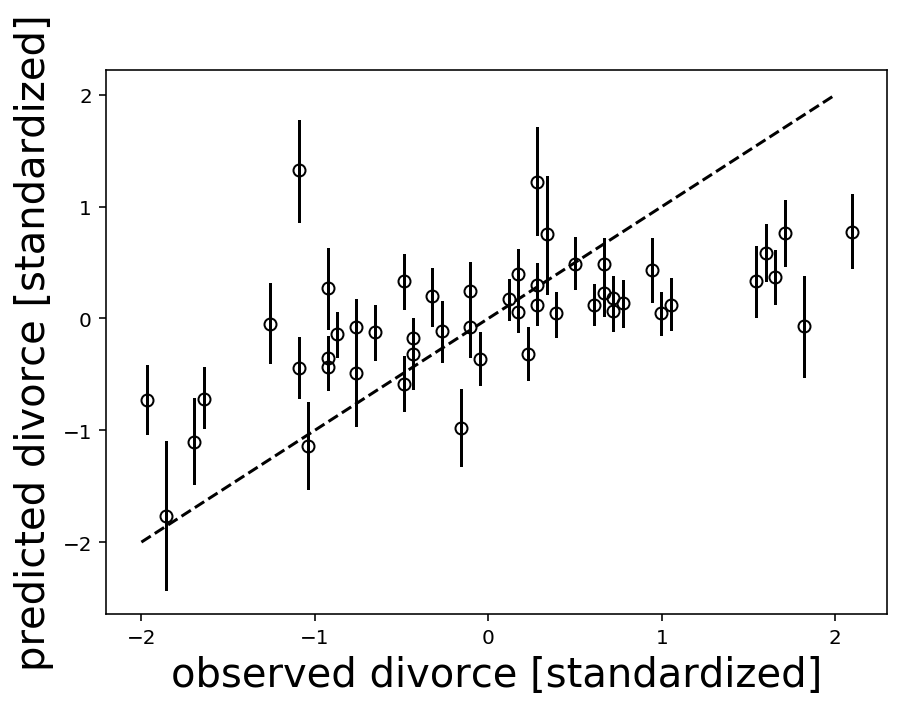

In [ ]:
mu_lower, mu_upper = credible_interval_from_samples(posterior_predictive_samples['mu'].T, 0.89)
mu_mean = posterior_predictive_samples['mu'].mean(axis=0)

figure(1, [7, 5])
plot(linspace(-2, 2), linspace(-2, 2), '--k') 
plot(data_standardized['Divorce'], mu_mean, 'ko', mfc='none')
## plot a verticle line for each credible interval
cred_ints = array([mu_lower, mu_upper])
divorce_stacked = array(data_standardized['Divorce'])[None, :]*ones((2, 1))
plot(divorce_stacked, cred_ints, 'k')

ylabel('predicted divorce [standardized]', fontsize=20)
xlabel('observed divorce [standardized]', fontsize=20);

### Warning: the above plot might look like a linear regression (similar to last week) but it this is not the meaning. The dashed line indicates where the prediction exactly matches the observed divorce rate. This would be the same dashed line even if we used nonlinear regression.

# Counterfactual plots
The idea is to generate posterior prediction samples with specific values of an intervention variable. First, we will look at an example where the intervention variable is age.
  1. Generate parameter posterior samples of the combined model (includes effect of A -> M)
  2. Generate an array of values for intervention variable (e.g., for age)
  3. Use parameter posterior samples and manipulated ages to generate posterior prediction samples (of M and D)
  4. Plot the corresponding trends for M and D vs the intervention variable

In [ ]:
with pm.Model() as model_5_4:
    ## A -> M
    sigma_M = pm.Exponential('sigma_M', 1)
    beta_AM = pm.Normal('beta_AM', 0, 0.5)
    alpha_M = pm.Normal('alpha_M', 0, 0.2)
    mu_M = pm.Deterministic('mu_m', alpha_M + beta_AM*data_standardized["MedianAgeMarriage"])
    marriage = pm.Normal('marriage', mu_M, sigma_M, observed=data_standardized["Marriage"])
    
    ## A -> D <- M
    sigma = pm.Exponential('sigma', 1)
    beta_A = pm.Normal('beta_A', mu=0, sd=0.5)
    beta_M = pm.Normal('beta_M', mu=0, sd=0.5)
    alpha = pm.Normal('alpha', mu=0, sd=0.2)
    ## Note that an underscore '_' is nothing special;
    ## it is just another character that can be part of a variable name.
    _mu = alpha + beta_M*marriage + beta_A*data_standardized["MedianAgeMarriage"]
    mu = pm.Deterministic('mu', _mu) ## we use this so that we can sample the posterior predictive later
    D = pm.Normal('divorce', mu=mu, sd=sigma, observed=data_standardized['Divorce'])
    ## MCMC
    _model_5_4_mcmc_samples = pm.sample(1000, tune=1000)
model_5_4_mcmc_samples = pm.trace_to_dataframe(_model_5_4_mcmc_samples)
model_5_4_mcmc_samples

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_M, beta_A, sigma, alpha_M, beta_AM, sigma_M]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


,beta_AM,alpha_M,beta_A,beta_M,alpha,sigma_M,mu_m__0,mu_m__1,mu_m__2,mu_m__3,...,mu__40,mu__41,mu__42,mu__43,mu__44,mu__45,mu__46,mu__47,mu__48,mu__49
0,-0.789349,0.107509,-0.542422,0.056100,-0.187535,0.652604,0.586083,0.649554,0.268726,1.220796,...,0.010275,0.174399,0.205419,1.153772,-0.611388,-0.332745,-0.101370,0.302991,-0.337874,0.777476
1,-0.741423,0.055821,-0.551635,0.075745,-0.184725,0.678659,0.505339,0.564956,0.207250,1.101515,...,0.016376,0.179842,0.221724,1.226049,-0.634056,-0.330502,-0.090768,0.324399,-0.351959,0.848776
2,-0.606560,0.005723,-0.351475,0.108282,0.098183,0.687631,0.373474,0.422247,0.129607,0.861207,...,0.226094,0.319184,0.379057,1.146975,-0.246803,0.011402,0.178372,0.455539,-0.054422,0.923979
3,-0.606560,0.005723,-0.351475,0.108282,0.098183,0.687631,0.373474,0.422247,0.129607,0.861207,...,0.226094,0.319184,0.379057,1.146975,-0.246803,0.011402,0.178372,0.455539,-0.054422,0.923979
4,-0.596747,0.006186,-0.568247,-0.002576,0.014370,0.645154,0.367987,0.415971,0.128066,0.847830,...,0.221824,0.405070,0.403645,1.266310,-0.369670,-0.143988,0.083864,0.494555,-0.096057,0.854330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-0.634518,0.076822,-0.530885,0.019290,-0.039999,0.645106,0.461523,0.512545,0.206416,0.971738,...,0.153735,0.320933,0.331599,1.183818,-0.420006,-0.185740,0.032273,0.420531,-0.159813,0.805210
3996,-0.698251,-0.081219,-0.860365,-0.193873,0.110793,0.716249,0.342123,0.398269,0.061392,0.903585,...,0.425593,0.738053,0.630854,1.531824,-0.284895,-0.148280,0.151687,0.733484,0.089358,0.853037
3997,-0.662898,0.027200,-0.679804,-0.277832,-0.081704,0.792571,0.429108,0.482411,0.162590,0.962143,...,0.167490,0.437349,0.283725,0.729771,-0.272457,-0.299075,-0.091599,0.341843,-0.003003,0.157336
3998,-0.696958,0.188488,-0.837399,-0.091450,-0.027032,0.708117,0.611046,0.667088,0.330835,1.171468,...,0.279006,0.565202,0.514636,1.598960,-0.507256,-0.269306,0.045698,0.632450,-0.122509,0.966458


### I didn't use the PyMC3 package to generate posterior prediction samples because I found it to be very confusing. It hides too many steps. We might use it in the future, but I think it helps to see the steps first.

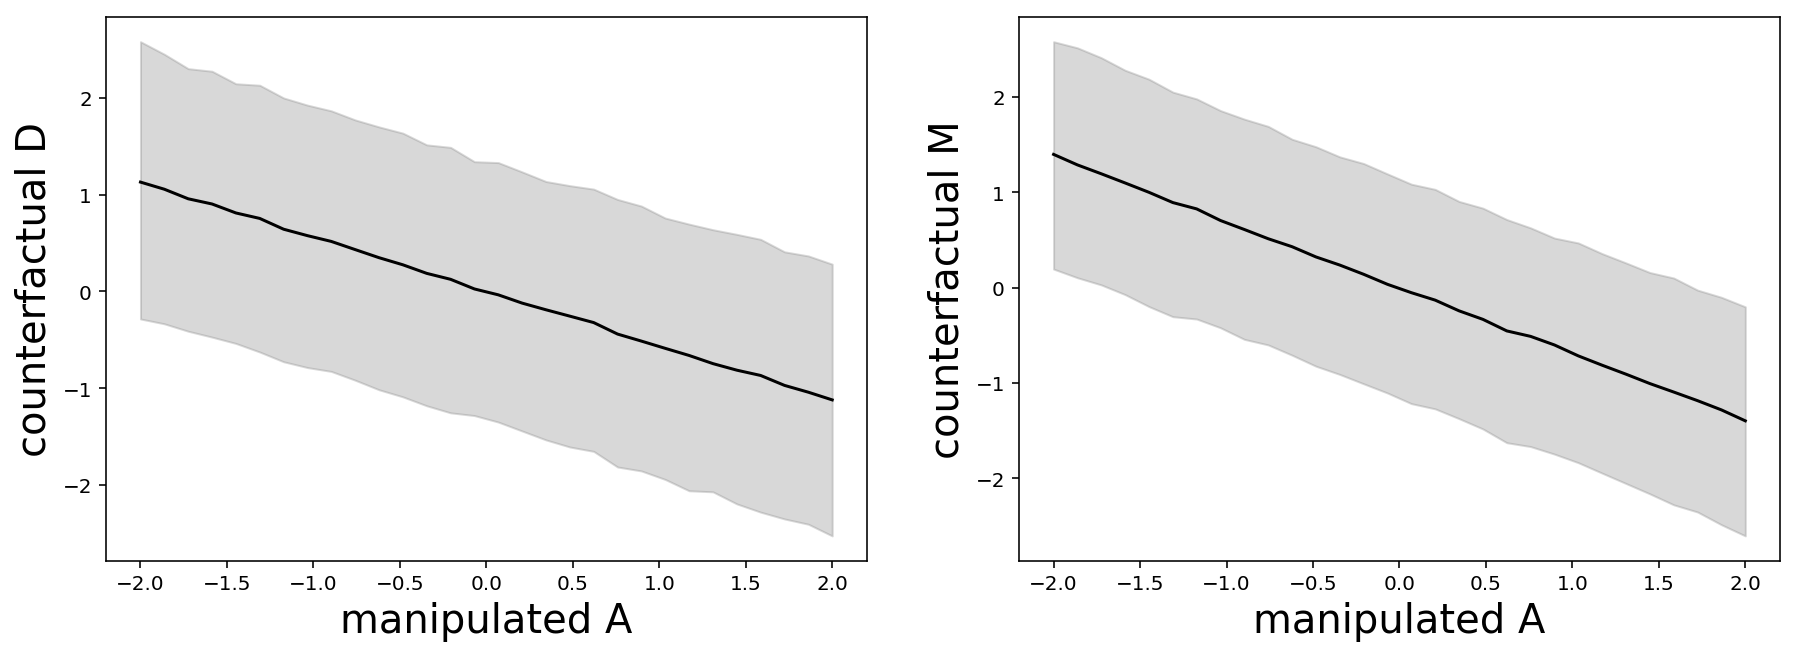

In [ ]:
N_cf = 30
N_posterior_samples = model_5_4_mcmc_samples.shape[0]
## intervention variable is Age
A_counter_factual = linspace(-2, 2, N_cf) ## the manipulated values for age

## first generate posterior predictive samples of M, using 
## parameter posterior samples and intervention variable
alpha_M_post = array(model_5_4_mcmc_samples['alpha_M'])
beta_AM_post = array(model_5_4_mcmc_samples['beta_AM'])
sigma_M_post = array(model_5_4_mcmc_samples['sigma_M'])
mu_M = (alpha_M_post[None, :] 
        + beta_AM_post[None, :]*A_counter_factual[:, None])
M = stats.norm.rvs(
    mu_M, 
    sigma_M_post[None, :], 
    size=(N_cf, N_posterior_samples))

## use above generated samples of M (along with parameter 
## posterior samples) to generate samples of D
alpha_post = array(model_5_4_mcmc_samples['alpha'])
beta_A_post = array(model_5_4_mcmc_samples['beta_A'])
beta_M_post = array(model_5_4_mcmc_samples['beta_M'])
sigma_post = array(model_5_4_mcmc_samples['sigma'])
mu = (alpha_post[None, :] 
      + beta_A_post[None, :]*A_counter_factual[:, None] 
      + beta_M_post[None, :]*M)
D = stats.norm.rvs(
    mu, 
    sigma_post[None, :], 
    size=(N_cf, N_posterior_samples))


## Plot the result: credible intervals etc
prob = 0.89
M_lower, M_upper = credible_interval_from_samples(M, prob)
D_lower, D_upper = credible_interval_from_samples(D, prob)

fig = figure(1, [15, 5])

fig.add_subplot(121)
fill_between(A_counter_factual, D_upper, D_lower, color='0.5', alpha=0.3)
plot(A_counter_factual, D.mean(axis=1), 'k')
ylabel('counterfactual D', fontsize=20)
xlabel('manipulated A', fontsize=20);

fig.add_subplot(122)
fill_between(A_counter_factual, M_upper, M_lower, color='0.5', alpha=0.3)
plot(A_counter_factual, M.mean(axis=1), 'k')
ylabel('counterfactual M', fontsize=20)
xlabel('manipulated A', fontsize=20);

## Let's look at another example, this time we will use marriage as the intervention variable
Since we have no causal relationship of M -> A, and because A influences D, we will set $A=0$ for this example.

In [ ]:
N_cf = 30
N_posterior_samples = model_5_4_mcmc_samples.shape[0]
## intervention variable is Age
M_counter_factual = linspace(-2, 2, N_cf) ## the manipulated values for age
A = zeros(N_cf)

## use above generated samples of M (along with parameter 
## posterior samples) to generate samples of D
alpha_post = array(model_5_4_mcmc_samples['alpha'])
beta_A_post = array(model_5_4_mcmc_samples['beta_A'])
beta_M_post = array(model_5_4_mcmc_samples['beta_M'])
sigma_post = array(model_5_4_mcmc_samples['sigma'])
mu = (alpha_post[None, :] 
      + beta_A_post[None, :]*A[:, None] 
      + beta_M_post[None, :]*M_counter_factual[:, None])
D = stats.norm.rvs(
    mu, 
    sigma_post[None, :], 
    size=(N_cf, N_posterior_samples))


## Plot the result: credible intervals etc
prob = 0.89
D_lower, D_upper = credible_interval_from_samples(D, prob)

figure(1, [7, 5])

fill_between(M_counter_factual, D_upper, D_lower, color='0.5', alpha=0.3)
plot(M_counter_factual, D.mean(axis=1), 'k')
ylabel('counterfactual D', fontsize=20)
xlabel('manipulated M', fontsize=20);

NameError: name 'model_5_4_mcmc_samples' is not defined

-----
# Next example: composition of milk across primate species, as well as some facts about those species, like body mass and brain size
-----
# TODO

In [ ]:
data_ex2 = pd.read_csv('Data/milk.csv', delimiter=";")
data_ex2

In [ ]:
data_ex2_standardized = pd.read_csv('Data/milk.csv', delimiter=";")
columns = ['mass', 'neocortex.perc', 'kcal.per.g']
data_ex2_standardized[columns] = (data_ex2[columns] - data_ex2[columns].mean())/data_ex2[columns].std()
data_ex2_standardized